# Age Determination

It is necessary to build a model that will determine the approximate age of a person from a photograph. There is a set of photographs of people with age indication

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

## EDA

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.shape

(7591, 2)

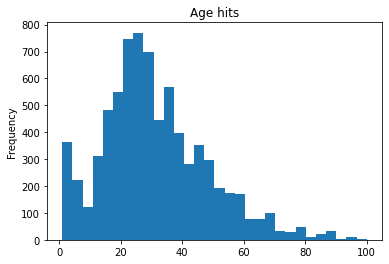

In [5]:
labels['real_age'].plot(kind='hist', title="Age hits", bins=30);

In [6]:
f, t = next(train_gen_flow)
f.shape

(32, 224, 224, 3)

**Resume**
- We have about 7.5 thousand images and the numerical value of the age, the number of images is enough for training
- Age adequate, normal distributed. As a consequence, we can have different final accuracy in different age ranges. In part, one could try to solve by isolating a separate model for some one or more age ranges. As part of this project, we will not do this
- Images (at least the first one) are 224x224 and have three color channels

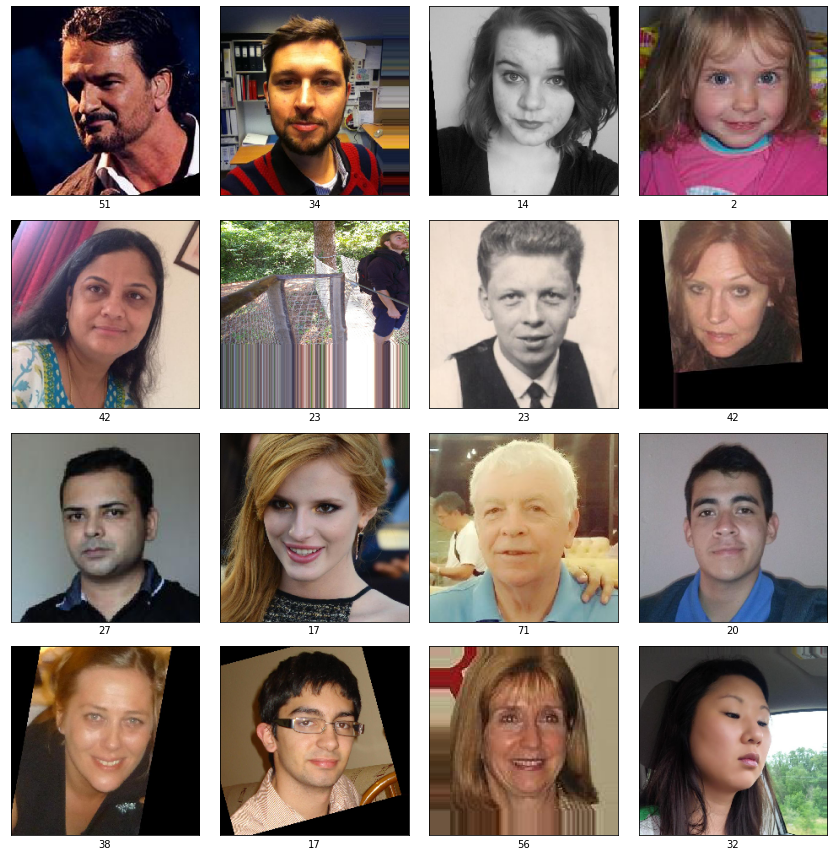

In [7]:
fig = plt.pyplot.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    f, t = next(train_gen_flow)
    plt.pyplot.imshow(f[i,:,:,:])
    plt.pyplot.xticks([])
    plt.pyplot.yticks([])
    plt.pyplot.xlabel(t[i])
    plt.pyplot.tight_layout()

**Resume**
- For the first images, the target values are adequate
- Basically, the face area is selected, but there are exceptions (therefore, you can either make a model for selecting a face, or train with offsets. We won’t do either, since the result meets the requirements, and without additional actions, training is faster)
- We will use the loss function MSE as a valid metric for the loss function and the networks are well trained on it
- Target metric set by MAE

## Modeling

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50



def load_train(path):
    labels = pd.read_csv(path+'/labels.csv')

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25,
    horizontal_flip=True,
    # width_shift_range=0.2,
    # height_shift_range=0.2
    )

    return datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path+'/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345
    )

def load_test(path):
    labels = pd.read_csv(path+'/labels.csv')

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    return datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path+'/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345
    )



def create_model(input_shape):

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 


    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```
# Results:

```

**Epoch 20/20**

**178/178 - 39s - loss: 8.5358 - mae: 2.2039 - val_loss: 61.7643 - val_mae: 5.9014**

Test MAE: 5.9014


## Consulation

- Actually 15 epochs instead of 20 would be enough
- The obtained MAE metric on the test sample 5.9, which satisfies the task
- The model is built and trained correctly